In [1]:
from PIL import Image
from scripts.predict import Predictor
Predictor_ = Predictor(model_path="unet.pth", device="cuda:0" , DEBUG=False)
img_path = "test_data/WhatsApp Image 2024-08-18 at 16.44.56_2a7d2b63.jpg"
bg_path = "test_data/test_bg.jpg"
image = Image.open(img_path).convert('RGB')
background = Image.open(bg_path).convert('RGB')


op = Predictor_.background_changed_img(image=image, background_img=background)

Using device: cuda:0


/workspace/saumilya/Unet/scripts/predict.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


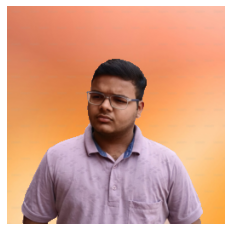

In [2]:
import matplotlib.pyplot as plt

# Convert the tensor to CPU and detach it for plotting
op_cpu = op.cpu().detach().numpy()

# Select the first channel for visualization
plt.imshow(op_cpu[0].transpose(1, 2, 0))  # Transpose to match (H, W, C) format
plt.axis('off')  # Turn off axis
plt.show()

In [4]:
import cv2 as cv

vid_src = "test_data/WIN_20250328_20_27_55_Pro.mp4"
vid = cv.VideoCapture(vid_src)

# Check if the video source is opened successfully
if not vid.isOpened():
    print("Error: Could not open video source.")
else:
    while True:
        ret, frame = vid.read()
        if not ret:
            break

        # Convert the frame to PIL Image
        image = Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

        # Perform background change
        op = Predictor_.background_changed_img(image=image, background_img=background)

        # Convert the tensor to CPU and detach it for visualization
        op_cpu = op.cpu().detach().numpy()

        # Convert the processed frame back to BGR format for saving
        processed_frame = (op_cpu[0].transpose(1, 2, 0) * 255).astype('uint8')
        processed_frame_bgr = cv.cvtColor(processed_frame, cv.COLOR_RGB2BGR)

        # Initialize the video writer only once
        if 'out' not in locals():
            fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
            out = cv.VideoWriter('output_video.mp4', fourcc, 30.0, 
                                 (processed_frame_bgr.shape[1], processed_frame_bgr.shape[0]))

        # Write the frame to the output video
        out.write(processed_frame_bgr)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    vid.release()
    if 'out' in locals():
        out.release()
    print("Video processing completed and saved as 'output_video.mp4'.")


Video processing completed and saved as 'output_video.mp4'.


In [5]:
! pwd

/workspace/saumilya/Unet


In [6]:
import cv2 as cv

vid_src = "test_data/WIN_20250328_20_27_55_Pro.mp4"
vid = cv.VideoCapture(vid_src)

# Check if the video source is opened successfully
if not vid.isOpened():
    print("Error: Could not open video source.")
else:
    while True:
        ret, frame = vid.read()
        if not ret:
            break

        # Convert the frame to PIL Image
        image = Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

        # Perform background change
        op = Predictor_.background_changed_img(image=image, background_img=background)

        # Convert the tensor to CPU and detach it for visualization
        op_cpu = op.cpu().detach().numpy()

        # Convert the processed frame back to BGR format for saving
        processed_frame = (op_cpu[0].transpose(1, 2, 0) * 255).astype('uint8')
        processed_frame_bgr = cv.cvtColor(processed_frame, cv.COLOR_RGB2BGR)

        # Initialize the video writer only once
        if 'out' not in locals():
            fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
            out = cv.VideoWriter('output_video.mp4', fourcc, 30.0, 
                                 (processed_frame_bgr.shape[1], processed_frame_bgr.shape[0]))

        # Write the frame to the output video
        out.write(processed_frame_bgr)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    vid.release()
    if 'out' in locals():
        out.release()
    print("Video processing completed and saved as 'output_video.mp4'.")


Video processing completed and saved as 'output_video.mp4'.


In [8]:
import cv2 as cv
import torch
from PIL import Image
import numpy as np
from torchvision import transforms

def process_video(video_path, background_img_path, output_video_path="output_video.mp4"):
    """
    Processes a video by replacing its background using a segmentation model.
    
    Args:
        video_path (str): Path to the input video.
        background_img_path (str): Path to the background image.
        output_video_path (str): Path to save the processed video.

    Returns:
        str: Path to the saved video.
    """
    
    # Load video
    vid = cv.VideoCapture(video_path)
    if not vid.isOpened():
        print("Error: Could not open video source.")
        return None

    # Load and preprocess background image (as PIL Image)
    background = Image.open(background_img_path).convert('RGB')

    # Initialize the video writer
    out = None

    while True:
        ret, frame = vid.read()
        if not ret:
            break

        # Convert frame to PIL Image
        image = Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

        # Perform background replacement
        op = Predictor_.background_changed_img(image, background)

        # Convert tensor to NumPy array
        op_cpu = op.cpu().detach().numpy()

        # Convert back to BGR format for OpenCV saving
        processed_frame = (op_cpu[0].transpose(1, 2, 0) * 255).astype('uint8')
        processed_frame_bgr = cv.cvtColor(processed_frame, cv.COLOR_RGB2BGR)

        # Initialize video writer if not already done
        if out is None:
            fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
            height, width = processed_frame_bgr.shape[:2]
            out = cv.VideoWriter(output_video_path, fourcc, 30.0, (width, height))

        # Write frame to video
        out.write(processed_frame_bgr)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    vid.release()
    if out is not None:
        out.release()

    print(f"Video processing completed. Saved at: {output_video_path}")
    return output_video_path

# Example usage
video_path = "test_data/WIN_20250328_20_27_55_Pro.mp4"
background_path = "test_data/test_bg.jpg"
output_path = process_video(video_path, background_path)

# Print the final saved video path
print("Processed video saved at:", output_path)


Video processing completed. Saved at: output_video.mp4
Processed video saved at: output_video.mp4
